In [38]:
#!pip install prophet
#!pip install plotly
# Note: If your environment doesn't support "!mamba install", use "!pip install"

## Importing Required Libraries

In [39]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [40]:
# Specify the path to the consumption CSV file and the encoding
consumption_csv_file_path = 'hanoiweather.csv'
#csv_encoding = 'latin5'  # or 'ISO-8859-9'

In [41]:
# Load your dataframes (assuming they are CSV files, change the file paths if necessary)

# Read the consumption CSV file into a DataFrame with the specified encoding
data = pd.read_csv(consumption_csv_file_path)

The ```.head()``` method returns the first five rows (or as many as you specify within the parentheses) of a dataset. It is useful for quickly testing if your object has the right type of data.

In [42]:
# To quickly testing
data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Hà Nội,1990-01-01,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,...,NaN,NaN,NaN,1990-01-01T06:33:41,1990-01-01T17:26:18,0.14,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
1,Hà Nội,1990-01-02,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,...,NaN,NaN,NaN,1990-01-02T06:34:00,1990-01-02T17:26:56,0.18,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
2,Hà Nội,1990-01-03,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,...,NaN,NaN,NaN,1990-01-03T06:34:18,1990-01-03T17:27:34,0.22,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
3,Hà Nội,1990-01-04,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,...,NaN,NaN,NaN,1990-01-04T06:34:35,1990-01-04T17:28:12,0.25,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
4,Hà Nội,1990-01-05,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,...,NaN,NaN,NaN,1990-01-05T06:34:51,1990-01-05T17:28:51,0.29,Overcast,Cloudy skies throughout the day.,cloudy,48820099999


# Data Exploring and Pre-processing

The ```.dtypes``` method returns the data type of each column.

In [43]:
data.dtypes

name                 object
datetime             object
tempmax             float64
tempmin             float64
temp                float64
feelslikemax        float64
feelslikemin        float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
precipprob          float64
precipcover         float64
preciptype           object
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation      float64
solarenergy         float64
uvindex             float64
severerisk          float64
sunrise              object
sunset               object
moonphase           float64
conditions           object
description          object
icon                 object
stations             object
dtype: object

In [44]:
# Translating column names to English
'''consumption_data = consumption_data.rename(columns={
    'Tarih': 'Date',
    'Saat': 'Hour',
    'Tüketim Miktarı (MWh)': 'Consumption Amount (MWh)'
})'''

"consumption_data = consumption_data.rename(columns={\n    'Tarih': 'Date',\n    'Saat': 'Hour',\n    'Tüketim Miktarı (MWh)': 'Consumption Amount (MWh)'\n})"

The code below will remove the commas used as thousand separators and then convert the column to the float data type.

In [45]:
# Clean invalid columns
null_pct = data.apply(pd.isnull).sum()/data.shape[0]

In [46]:
null_pct

name                0.000000
datetime            0.000000
tempmax             0.004546
tempmin             0.004546
temp                0.004546
feelslikemax        0.004546
feelslikemin        0.004546
feelslike           0.004546
dew                 0.004546
humidity            0.004546
precip              0.066752
precipprob          0.004546
precipcover         0.000000
preciptype          0.541590
snow                0.728208
snowdepth           0.726533
windgust            0.722466
windspeed           0.000000
winddir             0.006221
sealevelpressure    0.007895
cloudcover          0.004546
visibility          0.004546
solarradiation      0.582582
solarenergy         0.582582
uvindex             0.582582
severerisk          0.932850
sunrise             0.000000
sunset              0.000000
moonphase           0.000000
conditions          0.004546
description         0.004546
icon                0.004546
stations            0.004546
dtype: float64

In [47]:
valid_columns = data.columns[null_pct < .005]

In [48]:
data = data.dropna(subset = ['tempmax', 'tempmin','temp'])

In [49]:
data = data[valid_columns].copy()

The ```to_datetime()``` method is used to transform a scalar, array-like, Series, or DataFrame/dict-like object into a datetime object within the Pandas library.

This conversion is necessary for using the Prophet model, which requires the input data to be in datetime format.

In [50]:
# Combine the 'Date' and 'Hour' columns into a single 'Datetime' column in the consumption_data dataframe
# The 'dayfirst=True' argument is used to correctly interpret dates with ambiguous formats
data['datetime'] = pd.to_datetime(data['datetime'])

In [51]:
data.set_index('datetime', inplace = True)

In [52]:
data

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precipprob,...,windspeed,cloudcover,visibility,sunrise,sunset,moonphase,conditions,description,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
1990-01-01,Hà Nội,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,0.0,...,7.2,100.0,10.0,1990-01-01T06:33:41,1990-01-01T17:26:18,0.14,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
1990-01-02,Hà Nội,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,0.0,...,7.2,100.0,17.1,1990-01-02T06:34:00,1990-01-02T17:26:56,0.18,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
1990-01-03,Hà Nội,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,0.0,...,7.2,100.0,19.9,1990-01-03T06:34:18,1990-01-03T17:27:34,0.22,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
1990-01-04,Hà Nội,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,0.0,...,7.2,100.0,9.7,1990-01-04T06:34:35,1990-01-04T17:28:12,0.25,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
1990-01-05,Hà Nội,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,0.0,...,3.6,98.6,11.4,1990-01-05T06:34:51,1990-01-05T17:28:51,0.29,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,Hà Nội,36.0,27.0,30.9,47.9,31.0,39.6,26.9,80.8,0.0,...,18.4,44.4,6.1,2024-04-26T05:29:23,2024-04-26T18:19:42,0.58,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,VVNB
2024-04-27,Hà Nội,40.0,27.0,32.2,44.7,31.2,38.6,24.7,69.9,0.0,...,16.6,8.8,7.7,2024-04-27T05:28:42,2024-04-27T18:20:04,0.61,Clear,Clear conditions throughout the day.,clear-day,"48820099999,48823099999,48825099999,4883109999..."
2024-04-28,Hà Nội,35.0,27.0,30.4,50.8,30.5,39.4,27.0,82.7,0.0,...,22.3,45.3,8.8,2024-04-28T05:28:02,2024-04-28T18:20:27,0.65,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999..."


## Prepare to Prophet

Prophet requires a specific format for your time series data, with two columns named 'ds' (the date or timestamp) and 'y' (the target variable you want to forecast).

The column containing the date-times must be named ```ds```.

The column containing the consumption values must be named ```y```.

In [53]:
# Rename columns to 'ds' and 'y'
data["y"] = data.shift(-1)['tempmax']
data = data.ffill()
data['ds'] = data.index

### Splitting Data into Training and Test Sets

In machine learning and time series analysis, it's common practice to split your dataset into training and test sets. This allows you to train your model on one portion of the data and evaluate its performance on another independent portion. Here's how you can split your `consumption_data` into training and test sets:


In [54]:
# Define the percentage of data to use for training (adjust as needed)
train_percentage = 0.8  # 80% for training

# Calculate the index to split the data
train_size = int(len(data) * train_percentage)

# Create the training dataset
train_data = data[:train_size]

# Create the test dataset
test_data = data[train_size:]

# Creating a Model

The Prophet model is configured to account for seasonality patterns within the data. Seasonality, referring to repetitive patterns or cycles occurring at regular intervals (e.g., daily, weekly, yearly), is often regarded as an essential aspect of time series data.

### Seasonality Configuration

Specifications regarding how different types of seasonality should be handled by the model are set.

In [55]:
# Initialize the Prophet model with built-in daily, weekly, and yearly seasonalities 
model = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = True)

```yearly_seasonality = True``` : This setting enables the model to account yearly seasonality. Yearly seasonality is crucial for the capturing of annual patterns in electricity consumption. For instance, the increase in electricity usage during summer and winter months can be accounted for with this setting.

```weekly_seasonality = True``` : Enabling weekly seasonality allows the model to capture patterns repeating on a weekly basis. In the context of electricity consumption, this may account for differences between weekdays and weekends, given that consumption patterns can vary.

```daily_seasonality = True```: Enabling this option lets the model recognize and use daily consumption patterns, which is helpful for situations with significant daily fluctuations, such as shift work or distinct daily routines, improving daily consumption trend forecasts.

### Fit the Model

Train the Prophet model on historical data using the ```fit``` method:

In [56]:
model.fit(train_data)

08:53:24 - cmdstanpy - INFO - Chain [1] start processing
08:53:25 - cmdstanpy - INFO - Chain [1] done processing


The ```model.component_modes``` attribute provides information about which of these components are included in the model. This attribute provides insights into how the model decomposes the time series data into its constituent parts, which can be helpful for understanding the patterns and trends captured by the model.

In [57]:
model.component_modes

{'additive': ['yearly',
  'weekly',
  'daily',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

If a component is active, its value will be 'additive' or 'multiplicative'. The 'additive' mode indicates that the component is added to the trend, and the 'multiplicative' mode indicates that the component is multiplied with the trend.

If a component is not active, it will not be considered in the forecasting.

# Forecasting

By using the ```predict()``` method, we can forecast future values as well as obtain fitted values for our historical data. If you're only interested in future values, ensure the input dataframe to predict only contains future dates

In [58]:
# Make forecasts on the test data
forecast = model.predict(test_data)

In [59]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-06-30,21.082486,30.259417,38.338047,21.082486,21.082486,13.285657,13.285657,13.285657,7.60215,...,0.018334,0.018334,0.018334,5.665172,5.665172,5.665172,0.0,0.0,0.0,34.368143
1,2017-07-01,21.083175,30.318990,38.468081,21.083175,21.083175,13.288092,13.288092,13.288092,7.60215,...,0.027616,0.027616,0.027616,5.658326,5.658326,5.658326,0.0,0.0,0.0,34.371267
2,2017-07-02,21.083864,30.167807,38.293708,21.083864,21.083864,13.314942,13.314942,13.314942,7.60215,...,0.061530,0.061530,0.061530,5.651261,5.651261,5.651261,0.0,0.0,0.0,34.398805
3,2017-07-03,21.084553,30.017160,38.491236,21.084553,21.084553,13.231904,13.231904,13.231904,7.60215,...,-0.013781,-0.013781,-0.013781,5.643535,5.643535,5.643535,0.0,0.0,0.0,34.316456
4,2017-07-04,21.085241,30.347484,38.676458,21.085241,21.085241,13.166393,13.166393,13.166393,7.60215,...,-0.070458,-0.070458,-0.070458,5.634701,5.634701,5.634701,0.0,0.0,0.0,34.251634


```forecasting``` : The variable will be a dataframe containing various columns, including the predicted values, uncertainty intervals, and other relevant forecast-related information.

-```'ds'``` : The timestamps for the future points.

-```'yhat'``` : The predicted values for electricity consumption at each future timestamp.

-```'yhat_lower'``` and ```'yhat_upper'``` : The lower and upper uncertainty range for predicted values shows the range where actual consumption values might be.

-Additional columns related to the trend and seasonality components of the forecast.

# Evaluating the Model


The Mean Absolute Percentage Error (MAPE) is a popular metric for evaluating the accuracy of forecasts. It calculates the absolute difference between the actual and forecasted values, divides it by the actual value, and then averages these relative errors across the dataset.

        The formula for MAPE is:

$$
\text{MAPE} = \frac{100}{n} \sum_{t=1}^{n} \left| \frac{A_t - F_t}{A_t} \right|
$$

Where:
n is the number of observations.

The function ```calculate_mape``` computes the Mean Absolute Percentage Error, a common metric for evaluating the accuracy of forecasts.

In [60]:
def calculate_mape(actual, forecast):
    """Calculate Mean Absolute Percentage Error (MAPE)"""
    mape = 100 * (abs((actual - forecast) / actual)).mean()
    return mape

In [61]:
# Extract the actual and forecasted values from the test_data and forecast dataframes
actual_values = test_data['y'].values
forecasted_values = forecast['yhat'].values

# Calculate MAPE
mape_value = calculate_mape(actual_values, forecasted_values)
print(f"MAPE: {mape_value:.2f}%")

MAPE: 11.01%


### MAPE: 9.07%

# Adjusting the Model

Electricity consumption forecasting requires precision and accuracy. When leveraging Prophet, a tool specifically designed for time series forecasting, it's imperative to fine-tune the model parameters to enhance performance. In this article, we'll delve into ways to adjust the Prophet model to better cater to the intricacies of electricity consumption patterns.

In [62]:
# Dropping the unnecessary columns
#data.drop(columns=['Date', 'YearMonth'], inplace=True)

# Rename columns to 'ds' and 'y'
#data.columns = ['y', 'ds', 'avgtemp']

# Prepare the holidays dataframe for Prophet
#special_events_data.columns = ['ds', 'holiday']

# Split data into train and test sets
train_size = int(len(data) * 0.8)  # 80% for training, adjust as needed
train_data = data[:train_size]
test_data = data[train_size:]

### Plot the Data

You may be familiar with ```Matplotib and Seaborn```, which are commonly taught in Data Science courses for basic plotting. However, for our time series data, we've selected for ```Plotly```, an ```interactive, open-source``` Python library that offers over 40 chart types, including statistical, financial, geographic, scientific, and 3D visualizations. 

Seaborn and Matplotlib provide limited interactivity, while Plotly provides highly interactive and responsive plots that can be zoomed, panned, and rotated.

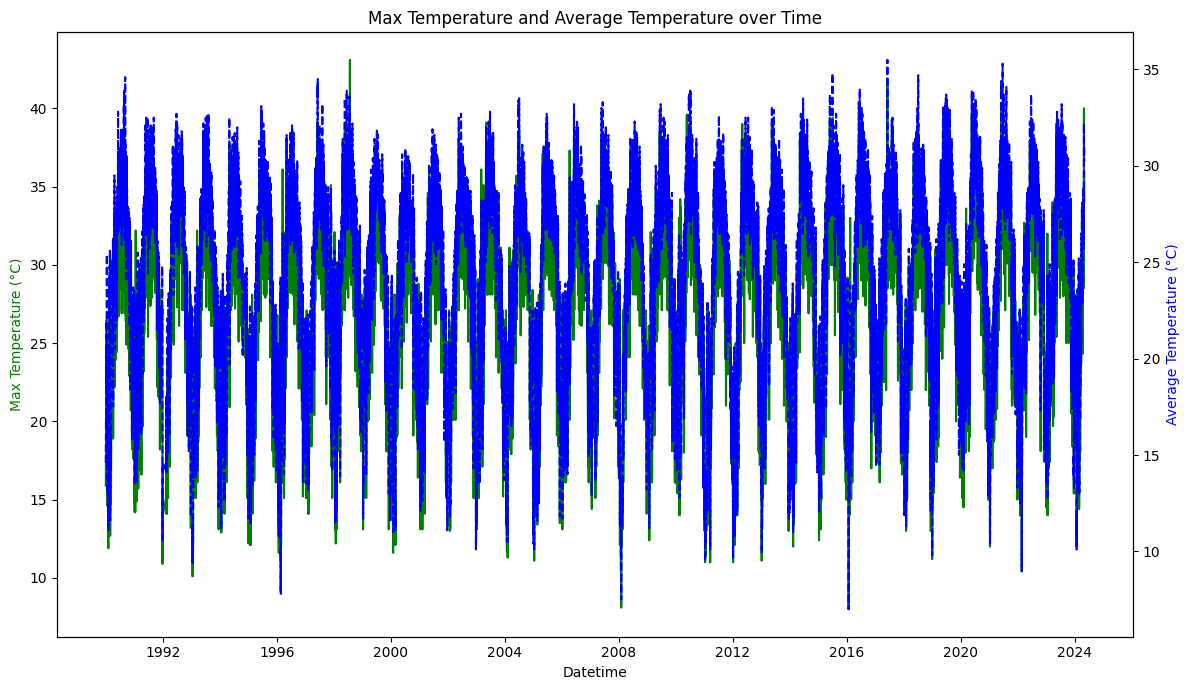

In [63]:
# Convert the 'ds' column to datetime format for plotting
data['ds'] = pd.to_datetime(data['ds'])

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

# Twin the axes for two different y-axes
ax2 = ax1.twinx()

# Plot data
ax1.plot(data['ds'], data['tempmax'], color='g', label='Tempmax (y)')
ax2.plot(data['ds'], data['temp'], color='b', linestyle='--', label='Average Temperature (avgtemp)')

# Set the y axis labels
ax1.set_ylabel('Max Temperature (°C)', color='g')
ax2.set_ylabel('Average Temperature (°C)', color='b')

# Set title and x-axis label
ax1.set_title('Max Temperature and Average Temperature over Time')
ax1.set_xlabel('Datetime')

# Display the plot
plt.tight_layout()
plt.show()


## Additional Regressors

Prophet allows you to include additional regressors in the forecasting model using the .```add_regressor()``` method. These regressors can be any continuous or binary variables that might have an impact on the target variable.

In [64]:
data.drop(columns=['icon','description','stations','conditions','name','sunset','sunrise'], inplace=True)

In [65]:
predictors = data.columns[~data.columns.isin(['y','ds','tempmax'])]

In [66]:
# Initialize the Prophet model with built-in daily, weekly, and yearly seasonalities 
# Also, use the `holidays_data` to account for special occasions.
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Add 'avgtemp' as an external regressor. This helps the model to consider the effects of average temperature
for p in predictors:
    model.add_regressor(p)

# Fit the model using the training data
model.fit(train_data)

# Use the fitted model to predict on the test dataset
forecast = model.predict(test_data)

# Extract the actual target values from the test dataset
actual_values = test_data['y'].values

# Extract the predicted values from the forecast
forecasted_values = forecast['yhat'].values

# Calculate the Mean Absolute Percentage Error (MAPE) between the actual and predicted values
mape_value = calculate_mape(actual_values, forecasted_values)

# Print the computed MAPE
print(mape_value)


08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:29 - cmdstanpy - INFO - Chain [1] done processing


6.674385160566187


### MAPE: 5.04%

## Tuning the Model Parameters

Depending on the initial results, the model can be tuned by adjusting parameters such as seasonality prior sclase, changepoint prior scale, and Fourier order for specific seasonality.

### Custom Seasonality

The ```.add_seasonality()``` method allows you to incorporate custom seasonalities into your forecasting model. Prophet automatically includes built-in yearly and weekly seasonalities, but for certain datasets, there might be other recurring patterns that aren't captured by these default seasonalities.



    model.add_seasonality(name='monthly', period=30, fourier_order=5, prior_scale:10)

-name: A string identifier for the seasonality.

-period: The duration of the seasonality cycle. For example, if you believe there's a pattern that repeats every 10 days in your data, you'd set period=10.

-fourier_order: This determines the complexity of the seasonality. A higher Fourier order will allow the seasonality to fit more complex patterns.

-prior_scale: This controls the flexibility of the seasonal component. Increasing it makes the seasonal component more flexible, while decreasing it makes it more rigid.


### Determining the Fourier Order and Prior Scale

The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for ```weekly_seasonality``` and 10 for ```yearly_seasonality```. [1]

The ```prior_scale``` parameter in Prophet controls the strength of the regularization applied to specific components of the model. A larger prior_scale allows the component to be more flexible, while a smaller prior_scale constrains it, making it more rigid.

#### Daily

In [67]:
# Lists to store results
fourier_orders = [48, 49, 50, 51, 52]  # Fourier orders

# Define the prior_scale values you want to test
prior_scales = [4.0, 4.5, 5.0, 5.25, 5.5]  # Example values, adjust based on needs

for order in fourier_orders:
    for scale in prior_scales:
        # Initialize the Prophet model with built-in daily, weekly, and yearly seasonalities
        # Also, use the `holidays_data` to account for special occasions
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)

        # Add 'avgtemp' as an external regressor. This helps the model to consider the effects of average temperature
        for p in predictors:
            model.add_regressor(p)
        
        # Add yearly seasonality with the current period and specified prior_scale
        model.add_seasonality(name='daily', period=1, fourier_order=order, prior_scale=scale)

        # Fit the model using the training data
        model.fit(train_data)

        # Use the fitted model to predict on the test dataset
        forecast = model.predict(test_data)

        # Extract the actual target values from the test dataset
        actual_values = test_data['y'].values

        # Extract the predicted values from the forecast
        forecasted_values = forecast['yhat'].values

        # Calculate the Mean Absolute Percentage Error (MAPE) between the actual and predicted values
        mape_value = calculate_mape(actual_values, forecasted_values)

        # Print the computed MAPE for the current fourier_order and prior_scale combination
        print(f"Fourier Order: {order}, Prior Scale: {scale}, MAPE: {mape_value:.2f}%")


08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:36 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 48, Prior Scale: 4.0, MAPE: 6.68%


08:53:39 - cmdstanpy - INFO - Chain [1] start processing
08:53:42 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 48, Prior Scale: 4.5, MAPE: 6.67%


08:53:46 - cmdstanpy - INFO - Chain [1] start processing
08:53:49 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 48, Prior Scale: 5.0, MAPE: 6.67%


08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:56 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 48, Prior Scale: 5.25, MAPE: 6.67%


08:53:59 - cmdstanpy - INFO - Chain [1] start processing
08:54:03 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 48, Prior Scale: 5.5, MAPE: 6.67%


08:54:06 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 49, Prior Scale: 4.0, MAPE: 6.67%


08:54:14 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 49, Prior Scale: 4.5, MAPE: 6.67%


08:54:22 - cmdstanpy - INFO - Chain [1] start processing
08:54:25 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 49, Prior Scale: 5.0, MAPE: 6.67%


08:54:29 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 49, Prior Scale: 5.25, MAPE: 6.67%


08:54:36 - cmdstanpy - INFO - Chain [1] start processing
08:54:40 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 49, Prior Scale: 5.5, MAPE: 6.67%


08:54:43 - cmdstanpy - INFO - Chain [1] start processing
08:54:47 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 50, Prior Scale: 4.0, MAPE: 6.67%


08:54:50 - cmdstanpy - INFO - Chain [1] start processing
08:54:54 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 50, Prior Scale: 4.5, MAPE: 6.67%


08:54:58 - cmdstanpy - INFO - Chain [1] start processing
08:55:01 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 50, Prior Scale: 5.0, MAPE: 6.67%


08:55:04 - cmdstanpy - INFO - Chain [1] start processing
08:55:09 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 50, Prior Scale: 5.25, MAPE: 6.68%


08:55:12 - cmdstanpy - INFO - Chain [1] start processing
08:55:15 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 50, Prior Scale: 5.5, MAPE: 6.68%


08:55:18 - cmdstanpy - INFO - Chain [1] start processing
08:55:22 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 51, Prior Scale: 4.0, MAPE: 6.67%


08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:30 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 51, Prior Scale: 4.5, MAPE: 6.67%


08:55:33 - cmdstanpy - INFO - Chain [1] start processing
08:55:36 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 51, Prior Scale: 5.0, MAPE: 6.67%


08:55:40 - cmdstanpy - INFO - Chain [1] start processing
08:55:44 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 51, Prior Scale: 5.25, MAPE: 6.67%


08:55:47 - cmdstanpy - INFO - Chain [1] start processing
08:55:51 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 51, Prior Scale: 5.5, MAPE: 6.67%


08:55:54 - cmdstanpy - INFO - Chain [1] start processing
08:55:58 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 52, Prior Scale: 4.0, MAPE: 6.67%


08:56:01 - cmdstanpy - INFO - Chain [1] start processing
08:56:05 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 52, Prior Scale: 4.5, MAPE: 6.67%


08:56:08 - cmdstanpy - INFO - Chain [1] start processing
08:56:13 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 52, Prior Scale: 5.0, MAPE: 6.67%


08:56:16 - cmdstanpy - INFO - Chain [1] start processing
08:56:20 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 52, Prior Scale: 5.25, MAPE: 6.67%


08:56:23 - cmdstanpy - INFO - Chain [1] start processing
08:56:27 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 52, Prior Scale: 5.5, MAPE: 6.67%


#### Weekly

When dealing with hourly data, the period of weekly seasonality is 168 hours (24 hours/day * 7 days/week). This is because the data repeats its pattern every 168 hours, which corresponds to a week.

As the Fourier order increases, the MAPE generally decreases, indicating that a more flexible seasonality (higher Fourier order) fits this particular dataset better.

However, be careful. A too-high Fourier order might overfit the training data, leading to poor generalization to new, unseen data.

In [68]:
# Lists to store results
fourier_orders = [4, 5, 6]  # Fourier orders

# Define the prior_scale values you want to test
prior_scales = [0.1, 0.5, 1.0, 5.0, 10.0]  # Example values, adjust based on needs

for order in fourier_orders:
    for scale in prior_scales:
        # Initialize the Prophet model with built-in daily, weekly, and yearly seasonalities
        # Also, use the `holidays_data` to account for special occasions
        model = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=True)

        # Add 'avgtemp' as an external regressor. This helps the model to consider the effects of average temperature
        for p in predictors:
            model.add_regressor(p)
        # Add yearly seasonality with the current period and specified prior_scale
        model.add_seasonality(name='weekly', period=7, fourier_order=order, prior_scale=scale)

        # Fit the model using the training data
        model.fit(train_data)

        # Use the fitted model to predict on the test dataset
        forecast = model.predict(test_data)

        # Extract the actual target values from the test dataset
        actual_values = test_data['y'].values

        # Extract the predicted values from the forecast
        forecasted_values = forecast['yhat'].values

        # Calculate the Mean Absolute Percentage Error (MAPE) between the actual and predicted values
        mape_value = calculate_mape(actual_values, forecasted_values)

        # Print the computed MAPE for the current fourier_order and prior_scale combination
        print(f"Fourier Order: {order}, Prior Scale: {scale}, MAPE: {mape_value:.2f}%")


08:56:29 - cmdstanpy - INFO - Chain [1] start processing
08:56:30 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 0.1, MAPE: 6.67%


08:56:32 - cmdstanpy - INFO - Chain [1] start processing
08:56:33 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 0.5, MAPE: 6.67%


08:56:35 - cmdstanpy - INFO - Chain [1] start processing
08:56:36 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 1.0, MAPE: 6.67%


08:56:37 - cmdstanpy - INFO - Chain [1] start processing
08:56:39 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 5.0, MAPE: 6.67%


08:56:41 - cmdstanpy - INFO - Chain [1] start processing
08:56:42 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 10.0, MAPE: 6.67%


08:56:44 - cmdstanpy - INFO - Chain [1] start processing
08:56:45 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 5, Prior Scale: 0.1, MAPE: 6.67%


08:56:47 - cmdstanpy - INFO - Chain [1] start processing
08:56:49 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 5, Prior Scale: 0.5, MAPE: 6.67%


08:56:50 - cmdstanpy - INFO - Chain [1] start processing
08:56:52 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 5, Prior Scale: 1.0, MAPE: 6.67%


08:56:53 - cmdstanpy - INFO - Chain [1] start processing
08:56:55 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 5, Prior Scale: 5.0, MAPE: 6.67%


08:56:57 - cmdstanpy - INFO - Chain [1] start processing
08:56:58 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 5, Prior Scale: 10.0, MAPE: 6.67%


08:57:00 - cmdstanpy - INFO - Chain [1] start processing
08:57:02 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 6, Prior Scale: 0.1, MAPE: 6.67%


08:57:03 - cmdstanpy - INFO - Chain [1] start processing
08:57:05 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 6, Prior Scale: 0.5, MAPE: 6.67%


08:57:06 - cmdstanpy - INFO - Chain [1] start processing
08:57:08 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 6, Prior Scale: 1.0, MAPE: 6.67%


08:57:10 - cmdstanpy - INFO - Chain [1] start processing
08:57:11 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 6, Prior Scale: 5.0, MAPE: 6.67%


08:57:13 - cmdstanpy - INFO - Chain [1] start processing
08:57:14 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 6, Prior Scale: 10.0, MAPE: 6.67%


#### Yearly

In [69]:
# Lists to store results
fourier_orders = [1, 2, 3, 4]  # Fourier orders

# Define the prior_scale values you want to test
prior_scales = [0.1, 0.5, 1.0, 5.0, 10.0]  # Example values, adjust based on needs

for order in fourier_orders:
    for scale in prior_scales:
        # Initialize the Prophet model with built-in daily, weekly, and yearly seasonalities
        # Also, use the `holidays_data` to account for special occasions
        model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)

        # Add 'avgtemp' as an external regressor. This helps the model to consider the effects of average temperature
        for p in predictors:
            model.add_regressor(p)
        
        # Add yearly seasonality with the current period and specified prior_scale
        model.add_seasonality(name='yearly', period=365, fourier_order=order, prior_scale=scale)

        # Fit the model using the training data
        model.fit(train_data)

        # Use the fitted model to predict on the test dataset
        forecast = model.predict(test_data)

        # Extract the actual target values from the test dataset
        actual_values = test_data['y'].values

        # Extract the predicted values from the forecast
        forecasted_values = forecast['yhat'].values

        # Calculate the Mean Absolute Percentage Error (MAPE) between the actual and predicted values
        mape_value = calculate_mape(actual_values, forecasted_values)

        # Print the computed MAPE for the current fourier_order and prior_scale combination
        print(f"Fourier Order: {order}, Prior Scale: {scale}, MAPE: {mape_value:.2f}%")


08:57:16 - cmdstanpy - INFO - Chain [1] start processing
08:57:17 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 1, Prior Scale: 0.1, MAPE: 6.70%


08:57:18 - cmdstanpy - INFO - Chain [1] start processing
08:57:19 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 1, Prior Scale: 0.5, MAPE: 6.70%


08:57:20 - cmdstanpy - INFO - Chain [1] start processing
08:57:21 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 1, Prior Scale: 1.0, MAPE: 6.70%


08:57:22 - cmdstanpy - INFO - Chain [1] start processing
08:57:23 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 1, Prior Scale: 5.0, MAPE: 6.70%


08:57:25 - cmdstanpy - INFO - Chain [1] start processing
08:57:26 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 1, Prior Scale: 10.0, MAPE: 6.70%


08:57:27 - cmdstanpy - INFO - Chain [1] start processing
08:57:28 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 2, Prior Scale: 0.1, MAPE: 6.69%


08:57:29 - cmdstanpy - INFO - Chain [1] start processing
08:57:30 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 2, Prior Scale: 0.5, MAPE: 6.69%


08:57:32 - cmdstanpy - INFO - Chain [1] start processing
08:57:33 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 2, Prior Scale: 1.0, MAPE: 6.69%


08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:35 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 2, Prior Scale: 5.0, MAPE: 6.69%


08:57:36 - cmdstanpy - INFO - Chain [1] start processing
08:57:37 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 2, Prior Scale: 10.0, MAPE: 6.69%


08:57:38 - cmdstanpy - INFO - Chain [1] start processing
08:57:40 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 3, Prior Scale: 0.1, MAPE: 6.69%


08:57:41 - cmdstanpy - INFO - Chain [1] start processing
08:57:42 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 3, Prior Scale: 0.5, MAPE: 6.69%


08:57:43 - cmdstanpy - INFO - Chain [1] start processing
08:57:44 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 3, Prior Scale: 1.0, MAPE: 6.69%


08:57:45 - cmdstanpy - INFO - Chain [1] start processing
08:57:47 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 3, Prior Scale: 5.0, MAPE: 6.69%


08:57:48 - cmdstanpy - INFO - Chain [1] start processing
08:57:49 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 3, Prior Scale: 10.0, MAPE: 6.69%


08:57:50 - cmdstanpy - INFO - Chain [1] start processing
08:57:51 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 0.1, MAPE: 6.68%


08:57:53 - cmdstanpy - INFO - Chain [1] start processing
08:57:54 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 0.5, MAPE: 6.68%


08:57:55 - cmdstanpy - INFO - Chain [1] start processing
08:57:56 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 1.0, MAPE: 6.68%


08:57:58 - cmdstanpy - INFO - Chain [1] start processing
08:57:59 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 5.0, MAPE: 6.68%


08:58:00 - cmdstanpy - INFO - Chain [1] start processing
08:58:01 - cmdstanpy - INFO - Chain [1] done processing


Fourier Order: 4, Prior Scale: 10.0, MAPE: 6.68%


#### Evaluating the Custom Seasonality

While increasing the Fourier number improves fit, there is a risk of overfitting, especially for longer seasonality. Considering the MAPE values of the prediction results made with different Fourier order values, the model will give more accurate results with Prophet's built-in values.

### Determining the Holidays Prior Scale

The ```holidays_prior_scale``` parameter helps control the regularization of the holiday effects in the forecasting model. It determines the flexibility of the holiday effects and can be adjusted to achieve a better fit to the data based on the prominence of holidays in your dataset. If not specified, Prophet uses a default value of 10.0. [2]

A higher holidays_prior_scale allows the model to fit larger holiday effects, meaning holidays can have a more pronounced impact on the forecast.

A lower holidays_prior_scale makes the holiday effects more constrained, meaning the model will be less influenced by holidays.


In [70]:
# Define the prior_scale values you want to test
holidays_prior_scales = [0.05, 0.1, 0.2, 0.5]  # Example values, adjust based on needs

for scale in holidays_prior_scales:
    
    # Initialize the Prophet model with built-in daily, weekly, and yearly seasonalities
    # Also, use the `holidays_data` to account for special occasions
    model = Prophet(holidays_prior_scale=scale, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

    # Add 'avgtemp' as an external regressor. This helps the model to consider the effects of average temperature
    for p in predictors:
        model.add_regressor(p)

    # Fit the model using the training data
    model.fit(train_data)

    # Use the fitted model to predict on the test dataset
    forecast = model.predict(test_data)

    # Extract the actual target values from the test dataset
    actual_values = test_data['y'].values

    # Extract the predicted values from the forecast
    forecasted_values = forecast['yhat'].values

    # Calculate the Mean Absolute Percentage Error (MAPE) between the actual and predicted values
    mape_value = calculate_mape(actual_values, forecasted_values)

    # Print the computed MAPE for the current fourier_order and prior_scale combination
    print(f"Prior Scale: {scale}, MAPE: {mape_value:.2f}%")


08:58:03 - cmdstanpy - INFO - Chain [1] start processing
08:58:05 - cmdstanpy - INFO - Chain [1] done processing


Prior Scale: 0.05, MAPE: 6.68%


08:58:06 - cmdstanpy - INFO - Chain [1] start processing
08:58:08 - cmdstanpy - INFO - Chain [1] done processing


Prior Scale: 0.1, MAPE: 6.67%


08:58:09 - cmdstanpy - INFO - Chain [1] start processing
08:58:11 - cmdstanpy - INFO - Chain [1] done processing


Prior Scale: 0.2, MAPE: 6.67%


08:58:12 - cmdstanpy - INFO - Chain [1] start processing
08:58:14 - cmdstanpy - INFO - Chain [1] done processing


Prior Scale: 0.5, MAPE: 6.67%


### Prior Scale: 0.1, MAPE: 4.99%

# Conclusion

Analyzed and predicted electricity consumption in Turkey with a data set extending from 2021 to 2023 with Time Series Analysis using Facebook Prophet. The Prophet model is initialized with daily, weekly, and annual seasonality and adjusted to account for special events using Special_events_data. Additionally, by setting holiday_prior_scale to 0.1 and including 'avgtemp' as an external regressor, the accuracy of the model in accounting for temperature effects was improved. This comprehensive approach, combined with data visualization, highlighted the relationship between electricity consumption and average temperatures, demonstrating Prophet's adaptability and the importance of a versatile strategy in precise time series forecasts.

In [71]:
# Initialize the Prophet model with built-in daily, weekly, and yearly seasonalities 
# Also, use the `holidays_data` to account for special occasions.
model = Prophet(holidays_prior_scale=0.1, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Add 'avgtemp' as an external regressor. This helps the model to consider the effects of average temperature
for p in predictors:
    model.add_regressor(p)

# Fit the model using the training data
model.fit(train_data)

# Use the fitted model to predict on the test dataset
forecast = model.predict(test_data)

# Extract the actual target values from the test dataset
actual_values = test_data['y'].values

# Extract the predicted values from the forecast
forecasted_values = forecast['yhat'].values

# Calculate the Mean Absolute Percentage Error (MAPE) between the actual and predicted values
mape_value = calculate_mape(actual_values, forecasted_values)

# Print the computed MAPE
print(f"MAPE: {mape_value:.2f}%")

08:58:15 - cmdstanpy - INFO - Chain [1] start processing
08:58:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 6.67%


In [72]:
# Initialize the Prophet model with the specified parameters
model = Prophet(
    holidays_prior_scale=0.1,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)

# Add 'avgtemp' as an external regressor
for p in predictors:
    model.add_regressor(p)

# Fit the model using the training data
model.fit(data)

# Generate a dataframe projecting 720 hours (or 30 days) into the future 
# without including the historical data
future = model.make_future_dataframe(periods=720, freq='h', include_history=False)

# Use the provided average temperature for the month to be predicted
predicted_avg_temp = 23.6
future['avgtemp'] = [predicted_avg_temp] * 720

# Use the fitted model to predict on the updated 'future' dataframe
forecast = model.predict(future)
forecast


08:58:18 - cmdstanpy - INFO - Chain [1] start processing
08:58:21 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Regressor 'tempmin' missing from dataframe

# References

[1] https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#:~:text=For%20reference%2C%20by%20default%20Prophet,and%2010%20for%20yearly%20seasonality.

[2] https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities:~:text=parameter%20holidays_prior_scale.-,By%20default%20this%20parameter%20is%2010%2C%20which%20provides%20very%20little%20regularization.%20Reducing%20this%20parameter%20dampens%20holiday%20effects%3A,-1%0A2%0A3